In [2]:
# Cell 1: Import Libraries
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Cell 2: Load data
movies = pd.read_csv('../data/processed/filtered_movies.csv')
ratings = pd.read_csv('../data/processed/filtered_ratings.csv')

print("Ratings columns:", ratings.columns.tolist())
print("\nMovies columns:", movies.columns.tolist())

Ratings columns: ['user_id', 'movie_id', 'rating', 'timestamp', 'year']

Movies columns: ['movie_id', 'title', 'genres', 'year', 'genre_count']


Shape of ratings DataFrame: (90267, 5)

First few rows of ratings:
   user_id  movie_id  rating            timestamp  year
0        1         1     4.0  2000-07-30 18:45:03  2000
1        1         3     4.0  2000-07-30 18:20:47  2000
2        1         6     4.0  2000-07-30 18:37:04  2000
3        1        47     5.0  2000-07-30 19:03:35  2000
4        1        50     5.0  2000-07-30 18:48:51  2000

Ratings per user statistics:
count     610.000000
mean      147.978689
std       216.877091
min        12.000000
25%        34.000000
50%        68.000000
75%       159.000000
max      2132.000000
dtype: float64

Ratings per movie statistics:
count    3649.000000
mean       24.737462
std        31.706562
min         5.000000
25%         7.000000
50%        13.000000
75%        28.000000
max       329.000000
dtype: float64


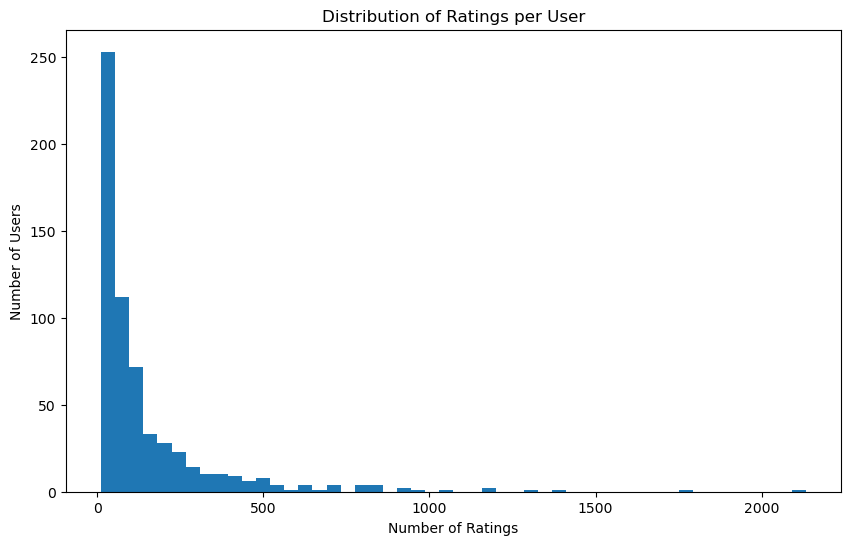

In [4]:
# Cell 3: Data Analysis
def analyze_data(ratings):
    print("Shape of ratings DataFrame:", ratings.shape)
    print("\nFirst few rows of ratings:")
    print(ratings.head())
    
    ratings_per_user = ratings.groupby('user_id').size()
    ratings_per_movie = ratings.groupby('movie_id').size()
    
    print("\nRatings per user statistics:")
    print(ratings_per_user.describe())
    print("\nRatings per movie statistics:")
    print(ratings_per_movie.describe())
    
    plt.figure(figsize=(10, 6))
    plt.hist(ratings_per_user, bins=50)
    plt.title('Distribution of Ratings per User')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.show()
    
    return ratings_per_user, ratings_per_movie

ratings_per_user, ratings_per_movie = analyze_data(ratings)

In [5]:
# Cell 4: Create Sparse Matrix
def create_sparse_matrix(ratings):
    user_ids = ratings['user_id'].unique()
    movie_ids = ratings['movie_id'].unique()
    
    user_id_map = {id: i for i, id in enumerate(user_ids)}
    movie_id_map = {id: i for i, id in enumerate(movie_ids)}
    
    rows = ratings['user_id'].map(user_id_map)
    cols = ratings['movie_id'].map(movie_id_map)
    data = ratings['rating']
    
    matrix = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
    
    print(f"Matrix shape: {matrix.shape}")
    print(f"Sparsity: {1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1]):.2%}")
    
    return matrix, user_id_map, movie_id_map

user_movie_matrix, user_id_map, movie_id_map = create_sparse_matrix(ratings)

Matrix shape: (610, 3649)
Sparsity: 95.94%


In [6]:
# Cell 5: Normalize Ratings
def normalize_ratings(R):
    R = R.tocsr()
    user_ratings_mean = np.array(R.sum(axis=1)).flatten() / np.diff(R.indptr)
    R_normalized = R.copy()
    
    for i in range(R.shape[0]):
        start, end = R.indptr[i], R.indptr[i+1]
        R_normalized.data[start:end] -= user_ratings_mean[i]
    
    return R_normalized, user_ratings_mean

user_movie_matrix_normalized, user_ratings_mean = normalize_ratings(user_movie_matrix)

# Verify normalization
print("\nVerifying normalization:")
for i in range(5):
    user_ratings = user_movie_matrix_normalized[i].data
    if len(user_ratings) > 0:
        print(f"User {i} mean: {user_ratings.mean():.4f}")
    else:
        print(f"User {i} has no ratings")


Verifying normalization:
User 0 mean: 0.0000
User 1 mean: 0.0000
User 2 mean: -0.0000
User 3 mean: -0.0000
User 4 mean: 0.0000


In [7]:
# Cell 6: SVD Model
def svd_model(R, k, learning_rate=0.01, reg_param=0.025, n_epochs=100, early_stopping_patience=8):
    R_coo = R.tocoo()
    
    mask = np.random.rand(len(R_coo.data)) < 0.85
    R_train = csr_matrix((R_coo.data[mask], 
                         (R_coo.row[mask], R_coo.col[mask])), 
                        shape=R.shape)
    R_val = csr_matrix((R_coo.data[~mask], 
                       (R_coo.row[~mask], R_coo.col[~mask])), 
                      shape=R.shape)
    
    n_users, n_items = R.shape
    P = np.random.normal(scale=0.1/np.sqrt(k), size=(n_users, k))
    Q = np.random.normal(scale=0.1/np.sqrt(k), size=(n_items, k))
    
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    
    mu = R_train.data.mean()
    
    best_rmse = float('inf')
    patience_counter = 0
    
    # Warm restart parameters
    cycle_length = 10
    min_lr = 0.001
    min_reg = 0.01
    
    users_train, items_train = R_train.nonzero()
    users_val, items_val = R_val.nonzero()
    
    for epoch in range(n_epochs):
        # Cosine annealing with warm restarts
        cycle = epoch % cycle_length
        current_learning_rate = min_lr + 0.5 * (learning_rate - min_lr) * (1 + np.cos(cycle * np.pi / cycle_length))
        current_reg = min_reg + 0.5 * (reg_param - min_reg) * (1 + np.cos(cycle * np.pi / cycle_length))
        
        idx = np.random.permutation(len(users_train))
        epoch_loss = 0
        
        for i in idx:
            u, i = users_train[i], items_train[i]
            r = R_train[u, i]
            prediction = mu + bu[u] + bi[i] + np.dot(P[u], Q[i].T)
            error = r - prediction
            
            bu[u] += current_learning_rate * (error - current_reg * bu[u])
            bi[i] += current_learning_rate * (error - current_reg * bi[i])
            P[u] += current_learning_rate * (error * Q[i] - current_reg * P[u])
            Q[i] += current_learning_rate * (error * P[u] - current_reg * Q[i])
            
            epoch_loss += error**2
        
        val_predictions = mu + bu[users_val] + bi[items_val] + np.sum(P[users_val] * Q[items_val], axis=1)
        val_true = R_val[users_val, items_val].A.ravel()
        
        rmse = np.sqrt(mean_squared_error(val_true, val_predictions))
        train_rmse = np.sqrt(epoch_loss / len(users_train))
        
        print(f"Epoch {epoch}, Train RMSE: {train_rmse:.4f}, Val RMSE: {rmse:.4f}, LR: {current_learning_rate:.6f}, Reg: {current_reg:.6f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            patience_counter = 0
            best_P, best_Q = P.copy(), Q.copy()
            best_bu, best_bi = bu.copy(), bi.copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return best_P, best_Q, best_bu, best_bi, mu

In [8]:
# Cell 7: Train Model
best_params = {
    'k': 16,
    'learning_rate': 0.012,
    'reg_param': 0.025,
    'n_epochs': 100,
    'early_stopping_patience': 8
}
print("Training final model with best parameters:", best_params)
P, Q, bu, bi, mu = svd_model(user_movie_matrix_normalized, **best_params)
print("Final model training complete.")

Training final model with best parameters: {'k': 16, 'learning_rate': 0.012, 'reg_param': 0.025, 'n_epochs': 100, 'early_stopping_patience': 8}
Epoch 0, Train RMSE: 0.9063, Val RMSE: 0.8810, LR: 0.012000, Reg: 0.025000
Epoch 1, Train RMSE: 0.8748, Val RMSE: 0.8689, LR: 0.011731, Reg: 0.024633
Epoch 2, Train RMSE: 0.8591, Val RMSE: 0.8621, LR: 0.010950, Reg: 0.023568
Epoch 3, Train RMSE: 0.8493, Val RMSE: 0.8580, LR: 0.009733, Reg: 0.021908
Epoch 4, Train RMSE: 0.8425, Val RMSE: 0.8554, LR: 0.008200, Reg: 0.019818
Epoch 5, Train RMSE: 0.8372, Val RMSE: 0.8536, LR: 0.006500, Reg: 0.017500
Epoch 6, Train RMSE: 0.8334, Val RMSE: 0.8530, LR: 0.004800, Reg: 0.015182
Epoch 7, Train RMSE: 0.8305, Val RMSE: 0.8522, LR: 0.003267, Reg: 0.013092
Epoch 8, Train RMSE: 0.8285, Val RMSE: 0.8516, LR: 0.002050, Reg: 0.011432
Epoch 9, Train RMSE: 0.8272, Val RMSE: 0.8514, LR: 0.001269, Reg: 0.010367
Epoch 10, Train RMSE: 0.8321, Val RMSE: 0.8512, LR: 0.012000, Reg: 0.025000
Epoch 11, Train RMSE: 0.8281, 

In [30]:
# In your notebook, add this cell after training
import pickle
import json

# 1. Save as pickle (binary format)
pickle_path = '../app/data/svd_model.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump({
        'P': P,
        'Q': Q,
        'bu': bu,
        'bi': bi,
        'mu': mu,
        'user_id_map': user_id_map,
        'movie_id_map': movie_id_map
    }, f)

# 2. Save as JSON (current approach)
json_path = '../app/data/model_components.json'
json_model = {
    'P': P.tolist(),
    'Q': Q.tolist(),
    'bu': bu.tolist(),
    'bi': bi.tolist(),
    'mu': float(mu),
    'user_id_map': {str(k): int(v) for k, v in user_id_map.items()},
    'movie_id_map': {str(k): int(v) for k, v in movie_id_map.items()}
}

with open(json_path, 'w') as f:
    json.dump(json_model, f)

# Verify both files
print(f"Pickle file size: {os.path.getsize(pickle_path) / 1024 / 1024:.2f} MB")
print(f"JSON file size: {os.path.getsize(json_path) / 1024 / 1024:.2f} MB")

Pickle file size: 0.64 MB
JSON file size: 1.56 MB


In [32]:
# Cell 9: Prediction Function
@lru_cache(maxsize=1000)
def predict(P, Q, bu, bi, mu, user, item):
    return mu + bu[user] + bi[item] + np.dot(P[user], Q[item].T)

In [34]:
# Cell 10: Recommendation Function
def recommend_movies(user_id, n=10, min_ratings=5):
    try:
        if user_id not in user_id_map:
            print(f"User {user_id} not found in the dataset.")
            return [], []
        
        user_idx = user_id_map[user_id]
        print(f"User index: {user_idx}")
        
        user_ratings = user_movie_matrix[user_idx].toarray().flatten()
        print(f"User ratings shape: {user_ratings.shape}")
        
        rated_count = np.count_nonzero(user_ratings)
        print(f"User {user_id} has {rated_count} ratings")
        
        if rated_count < min_ratings:
            print(f"User {user_id} has too few ratings for reliable recommendations.")
            return [], []
        
        unrated_movies = np.where(user_ratings == 0)[0]
        print(f"Number of unrated movies: {len(unrated_movies)}")
        
        if len(unrated_movies) == 0:
            print(f"User {user_id} has rated all available movies.")
            return [], []
        
        print(f"Shapes: P: {P.shape}, Q: {Q.shape}, bu: {bu.shape}, bi: {bi.shape}")
        print(f"user_idx: {user_idx}, max index in bu: {len(bu)-1}")
        print(f"max movie index: {len(bi)-1}, max unrated movie index: {unrated_movies.max()}")
        
        # Batch predictions
        batch_size = 1000
        raw_predictions = []
        for i in range(0, len(unrated_movies), batch_size):
            batch = unrated_movies[i:i+batch_size]
            predictions = mu + bu[user_idx] + bi[batch] + np.dot(P[user_idx], Q[batch].T)
            raw_predictions.extend(predictions)
        
        # Add confidence scores
        movie_rating_counts = np.bincount(user_movie_matrix.tocoo().col)
        confidence_scores = np.clip(movie_rating_counts[unrated_movies] / movie_rating_counts.max(), 0.5, 1)
        raw_predictions = np.array(raw_predictions) * confidence_scores
        
        # Scale predictions
        min_pred, max_pred = min(raw_predictions), max(raw_predictions)
        scaled_predictions = 1 + (raw_predictions - min_pred) * 4 / (max_pred - min_pred)
        
        # Get recommendations
        top_n = np.argsort(scaled_predictions)[::-1][:n]
        bottom_n = np.argsort(scaled_predictions)[:n]
        
        inverse_movie_id_map = {i: id for id, i in movie_id_map.items()}
        
        top_recommendations = []
        for i in top_n:
            movie_id = inverse_movie_id_map[unrated_movies[i]]
            # Changed 'movieId' to 'movie_id'
            movie_title = movies.loc[movies['movie_id'] == movie_id, 'title']
            if not movie_title.empty:
                top_recommendations.append((movie_title.iloc[0], scaled_predictions[i]))
            else:
                print(f"Movie ID {movie_id} not found in movies dataset")
        
        bottom_recommendations = []
        for i in bottom_n:
            movie_id = inverse_movie_id_map[unrated_movies[i]]
            # Changed 'movieId' to 'movie_id'
            movie_title = movies.loc[movies['movie_id'] == movie_id, 'title']
            if not movie_title.empty:
                bottom_recommendations.append((movie_title.iloc[0], scaled_predictions[i]))
            else:
                print(f"Movie ID {movie_id} not found in movies dataset")
        
        return top_recommendations, bottom_recommendations
        
    except Exception as e:
        print(f"Error generating recommendations: {e}")
        import traceback
        traceback.print_exc()
        return [], []

In [43]:
# Cell 11: Example Usage
def test_recommendations(user_id):
    print(f"Generating recommendations for user {user_id}")
    
    top_recommendations, bottom_recommendations = recommend_movies(user_id)
    
    print(f"\nTop 10 recommendations for user {user_id}:")
    if top_recommendations:
        for movie, score in top_recommendations:
            print(f"{movie}: {score:.2f}")
    else:
        print("No top recommendations available.")
    
    print(f"\nBottom 5 recommendations for user {user_id}:")
    if bottom_recommendations:
        for movie, score in bottom_recommendations[:5]:
            print(f"{movie}: {score:.2f}")
    else:
        print("No bottom recommendations available.")

# Test the system
test_recommendations(22)

Generating recommendations for user 22
User index: 21
User ratings shape: (3649,)
User 22 has 118 ratings
Number of unrated movies: 3531
Shapes: P: (610, 16), Q: (3649, 16), bu: (610,), bi: (3649,)
user_idx: 21, max index in bu: 609
max movie index: 3648, max unrated movie index: 3648

Top 10 recommendations for user 22:
The Matrix (1999): 5.00
Star Wars: Episode IV - A New Hope (1977): 4.98
The Silence of the Lambs (1991): 4.65
American Beauty (1999): 4.62
Star Wars: Episode V - The Empire Strikes Back (1980): 4.54
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981): 4.37
Terminator 2: Judgment Day (1991): 4.36
The Godfather: Part II (1974): 4.35
The Usual Suspects (1995): 4.20
Pulp Fiction (1994): 4.20

Bottom 5 recommendations for user 22:
Spice World (1997): 1.00
Jason X (2002): 1.18
Catwoman (2004): 1.24
Inspector Gadget (1999): 1.25
Police Academy: Mission to Moscow (1994): 1.29


In [38]:
# Verify the saved model
with open('../data/model_components.json', 'r') as f:
    saved_model = json.load(f)
    print("Saved model keys:", saved_model.keys())
    print("Number of users:", len(saved_model['user_id_map']))
    print("Number of movies:", len(saved_model['movie_id_map']))

Saved model keys: dict_keys(['P', 'Q', 'bu', 'bi', 'mu', 'user_id_map', 'movie_id_map'])
Number of users: 610
Number of movies: 3649
